# 2D-CNN pipeline (images ready)

In [67]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import iqr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
base_path = "/content/drive/MyDrive"
IMG_DIR = os.path.join(base_path, "images_16*16_proc_data/GASF_16_resamp_norm-1")
CSV_PATH = os.path.join(base_path, "target_train_488.csv")

In [70]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "RESAMP"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [71]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [72]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [73]:
# # ====== CNN model (as in Table 2) ======
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

#         self.flattened = 512 * 2 * 2
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)
#         x = self.relu(self.conv2(x)); x = self.pool(x)
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
#         x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)

**16*16 2D CNN**

In [74]:
# =============================================
# ====== 6. CNN Model (16x16 Input) ======
# =============================================
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.flattened = 512 * 1 * 1
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
        x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [75]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [76]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)


========== Fold 1/5 ==========


Training Fold 1:   5%|▌         | 10/200 [02:45<09:12,  2.91s/it]

Epoch 10/200 | Train Loss: 0.9929 | Val Loss: 1.0199


Training Fold 1:  10%|█         | 20/200 [02:55<02:56,  1.02it/s]

Epoch 20/200 | Train Loss: 0.9676 | Val Loss: 0.9800


Training Fold 1:  15%|█▌        | 30/200 [03:05<02:41,  1.05it/s]

Epoch 30/200 | Train Loss: 0.8238 | Val Loss: 0.9536


Training Fold 1:  20%|██        | 40/200 [03:14<02:36,  1.02it/s]

Epoch 40/200 | Train Loss: 0.6432 | Val Loss: 0.8040


Training Fold 1:  25%|██▌       | 50/200 [03:23<02:19,  1.08it/s]

Epoch 50/200 | Train Loss: 0.4793 | Val Loss: 0.8358


Training Fold 1:  26%|██▌       | 52/200 [03:27<09:49,  3.98s/it]


🛑 Early Stopping at epoch 53 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=4.368, R2=0.521, Bias=-0.600


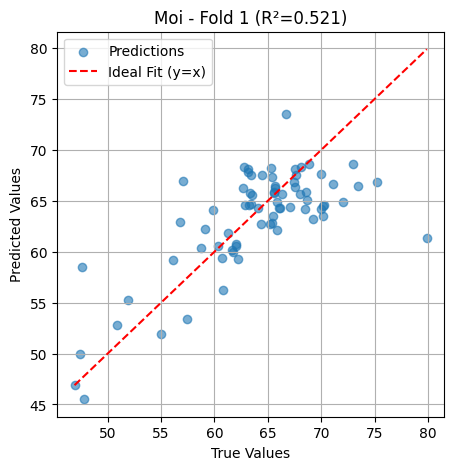

NDF: RMSE=5.250, R2=0.044, Bias=-0.709


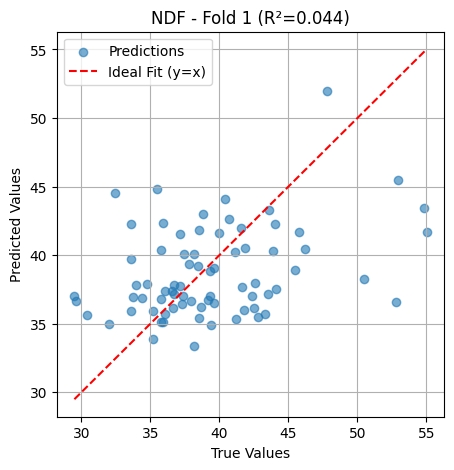

Starch: RMSE=8.621, R2=0.007, Bias=1.364


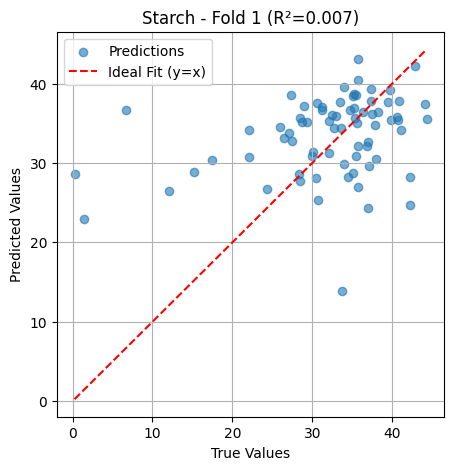


========== Fold 2/5 ==========


Training Fold 2:   5%|▌         | 10/200 [00:09<02:56,  1.07it/s]

Epoch 10/200 | Train Loss: 0.9733 | Val Loss: 1.0420


Training Fold 2:  10%|█         | 20/200 [00:18<02:44,  1.09it/s]

Epoch 20/200 | Train Loss: 0.8289 | Val Loss: 0.9397


Training Fold 2:  15%|█▌        | 30/200 [00:28<02:39,  1.06it/s]

Epoch 30/200 | Train Loss: 0.7476 | Val Loss: 0.8737


Training Fold 2:  20%|██        | 40/200 [00:38<02:49,  1.06s/it]

Epoch 40/200 | Train Loss: 0.5705 | Val Loss: 0.7511


Training Fold 2:  25%|██▌       | 50/200 [00:47<02:15,  1.10it/s]

Epoch 50/200 | Train Loss: 0.4592 | Val Loss: 0.7337


Training Fold 2:  30%|███       | 60/200 [00:56<02:08,  1.09it/s]

Epoch 60/200 | Train Loss: 0.2935 | Val Loss: 0.6976


Training Fold 2:  35%|███▌      | 70/200 [01:06<02:05,  1.03it/s]

Epoch 70/200 | Train Loss: 0.2333 | Val Loss: 0.6800


Training Fold 2:  39%|███▉      | 78/200 [01:14<01:56,  1.05it/s]


🛑 Early Stopping at epoch 79 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=5.088, R2=0.377, Bias=1.532


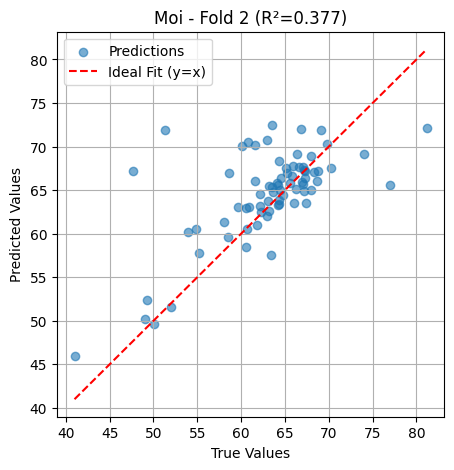

NDF: RMSE=4.893, R2=0.191, Bias=0.392


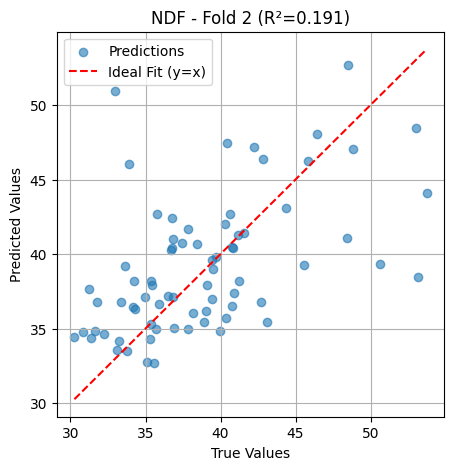

Starch: RMSE=7.487, R2=0.263, Bias=0.102


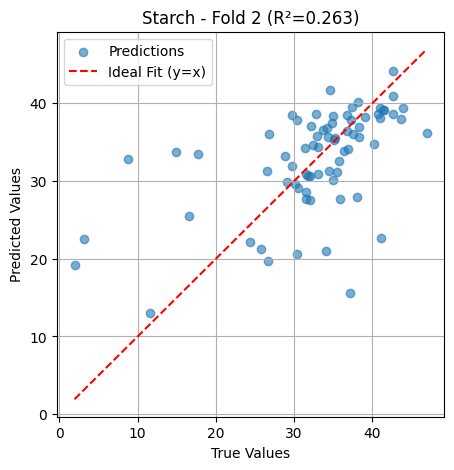


========== Fold 3/5 ==========


Training Fold 3:   5%|▌         | 10/200 [00:09<02:55,  1.08it/s]

Epoch 10/200 | Train Loss: 0.8783 | Val Loss: 1.2313


Training Fold 3:  10%|█         | 20/200 [00:19<02:48,  1.07it/s]

Epoch 20/200 | Train Loss: 0.7693 | Val Loss: 1.0998


Training Fold 3:  15%|█▌        | 30/200 [00:28<02:49,  1.01it/s]

Epoch 30/200 | Train Loss: 0.6115 | Val Loss: 1.1404


Training Fold 3:  20%|██        | 40/200 [00:37<02:25,  1.10it/s]

Epoch 40/200 | Train Loss: 0.4580 | Val Loss: 1.1089


Training Fold 3:  24%|██▍       | 48/200 [00:46<02:27,  1.03it/s]


🛑 Early Stopping at epoch 49 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=4.813, R2=0.250, Bias=-0.722


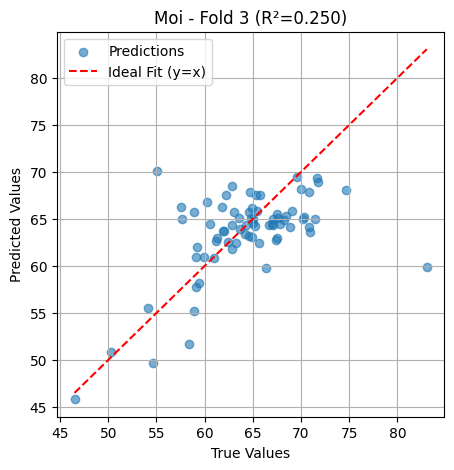

NDF: RMSE=8.037, R2=-0.062, Bias=-1.512


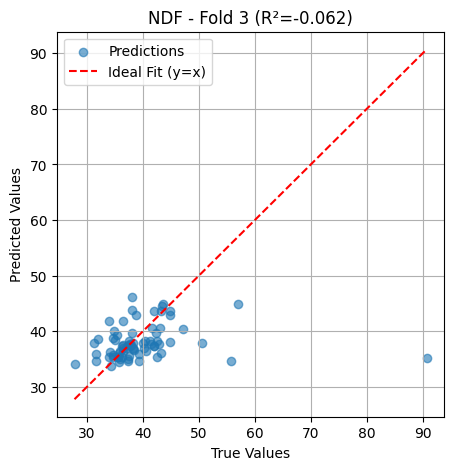

Starch: RMSE=8.473, R2=0.016, Bias=1.736


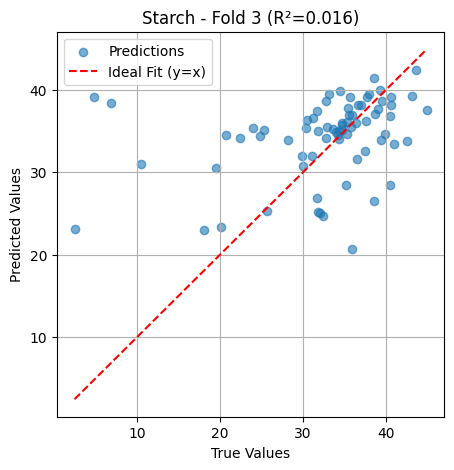


========== Fold 4/5 ==========


Training Fold 4:   5%|▌         | 10/200 [00:09<03:03,  1.04it/s]

Epoch 10/200 | Train Loss: 0.9961 | Val Loss: 0.9247


Training Fold 4:  10%|█         | 20/200 [00:19<02:53,  1.04it/s]

Epoch 20/200 | Train Loss: 0.8181 | Val Loss: 0.8209


Training Fold 4:  15%|█▌        | 30/200 [00:28<02:36,  1.08it/s]

Epoch 30/200 | Train Loss: 0.6555 | Val Loss: 0.9203


Training Fold 4:  17%|█▋        | 34/200 [00:33<02:43,  1.02it/s]


🛑 Early Stopping at epoch 35 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=4.832, R2=0.340, Bias=-1.179


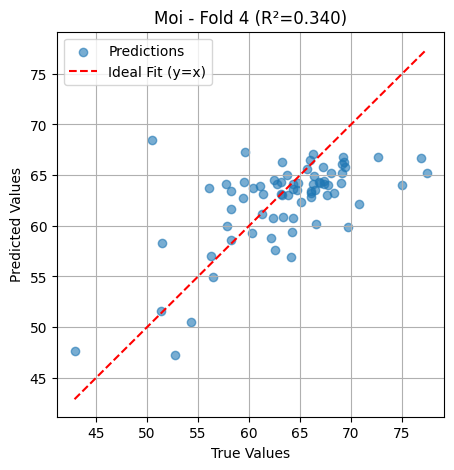

NDF: RMSE=5.259, R2=-0.030, Bias=-0.655


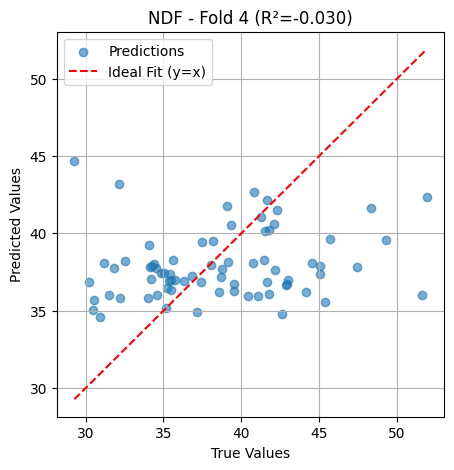

Starch: RMSE=8.047, R2=0.050, Bias=0.658


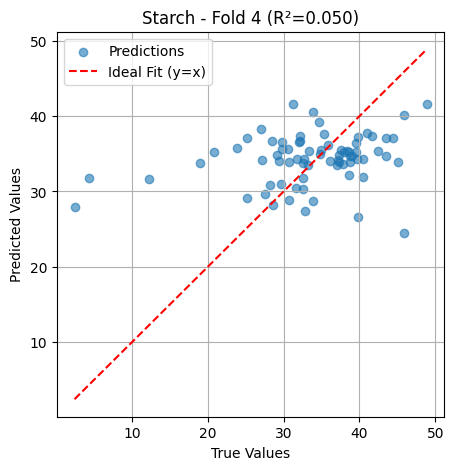


========== Fold 5/5 ==========


Training Fold 5:   5%|▌         | 10/200 [00:09<02:53,  1.09it/s]

Epoch 10/200 | Train Loss: 1.0098 | Val Loss: 0.8140


Training Fold 5:  10%|█         | 20/200 [00:18<02:44,  1.09it/s]

Epoch 20/200 | Train Loss: 0.8592 | Val Loss: 0.7304


Training Fold 5:  15%|█▌        | 30/200 [00:28<02:40,  1.06it/s]

Epoch 30/200 | Train Loss: 0.6976 | Val Loss: 0.7188


Training Fold 5:  20%|██        | 40/200 [00:37<02:41,  1.01s/it]

Epoch 40/200 | Train Loss: 0.4883 | Val Loss: 0.6996


Training Fold 5:  25%|██▌       | 50/200 [00:46<02:18,  1.09it/s]

Epoch 50/200 | Train Loss: 0.3338 | Val Loss: 0.6770


Training Fold 5:  30%|███       | 60/200 [00:56<02:10,  1.08it/s]

Epoch 60/200 | Train Loss: 0.2700 | Val Loss: 0.6879


Training Fold 5:  30%|███       | 61/200 [00:58<02:13,  1.04it/s]


🛑 Early Stopping at epoch 62 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=4.873, R2=0.415, Bias=-1.003


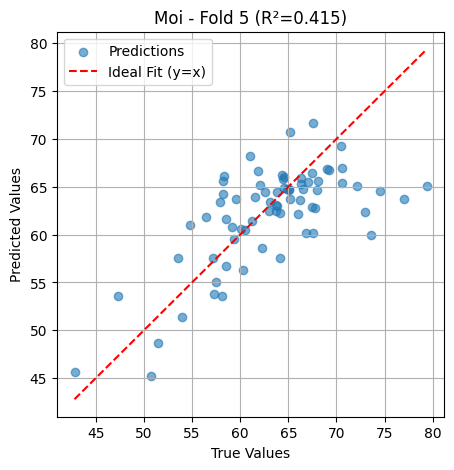

NDF: RMSE=5.575, R2=-0.336, Bias=-0.506


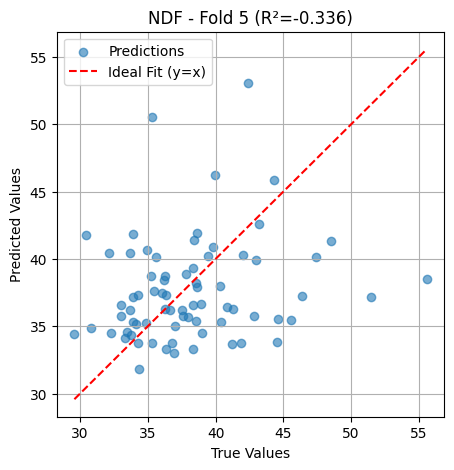

Starch: RMSE=7.724, R2=-0.227, Bias=0.679


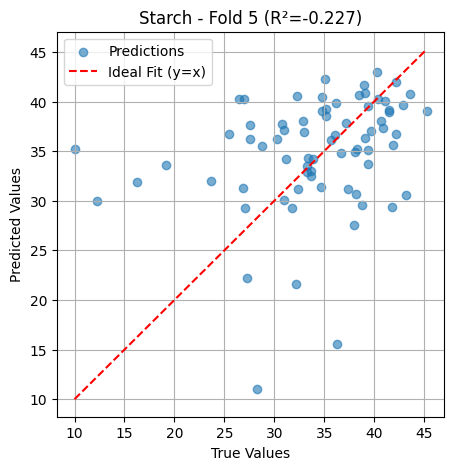



===== 📊 Average Results Across All Folds =====
Moi: Avg RMSE=4.795, Avg R2=0.381, Avg Bias=-0.394
NDF: Avg RMSE=5.803, Avg R2=-0.039, Avg Bias=-0.598
Starch: Avg RMSE=8.070, Avg R2=0.022, Avg Bias=0.908


In [77]:
# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# To store results for all folds
fold_metrics = {t: {'RMSE': [], 'R2': [], 'Bias': []} for t in TARGETS}

for fold, (t_idx, v_idx) in enumerate(kf.split(np.arange(len(trainval_idx)))):
    print(f"\n========== Fold {fold + 1}/{n_splits} ==========")

    # DataLoaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Early Stopping parameters =====
    best_val_loss = float('inf')
    patience = 15
    wait = 0
    best_model_state = None

    # ===== Training =====
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training Fold {fold + 1}"):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb.to(device))
                loss = criterion(preds, yb.to(device))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n🛑 Early Stopping at epoch {epoch} (no improvement for {patience} epochs)")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ===== Load best model =====
    model.load_state_dict(best_model_state)

    # ===== Validation (Final Metrics) =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        rmse, r2, bias = metrics[i]['RMSE'], metrics[i]['R2'], metrics[i]['Bias']
        fold_metrics[t]['RMSE'].append(rmse)
        fold_metrics[t]['R2'].append(r2)
        fold_metrics[t]['Bias'].append(bias)
        print(f"{t}: RMSE={rmse:.3f}, R2={r2:.3f}, Bias={bias:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5, 5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold + 1} (R²={r2:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

# =============================================
# ====== Average Metrics Across Folds ======
# =============================================
print("\n\n===== 📊 Average Results Across All Folds =====")
for t in TARGETS:
    avg_rmse = np.mean(fold_metrics[t]['RMSE'])
    avg_r2   = np.mean(fold_metrics[t]['R2'])
    avg_bias = np.mean(fold_metrics[t]['Bias'])
    print(f"{t}: Avg RMSE={avg_rmse:.3f}, Avg R2={avg_r2:.3f}, Avg Bias={avg_bias:.3f}")



=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.9425 | Val Loss: 0.8935
Epoch 20/200 | Train Loss: 0.7748 | Val Loss: 0.7110
Epoch 30/200 | Train Loss: 0.5601 | Val Loss: 0.5188
Epoch 40/200 | Train Loss: 0.3920 | Val Loss: 0.2846
Epoch 50/200 | Train Loss: 0.2974 | Val Loss: 0.2205
Epoch 60/200 | Train Loss: 0.2657 | Val Loss: 0.1617
Epoch 70/200 | Train Loss: 0.2105 | Val Loss: 0.1328
Epoch 80/200 | Train Loss: 0.1805 | Val Loss: 0.1981
Epoch 90/200 | Train Loss: 0.1546 | Val Loss: 0.1128
Epoch 100/200 | Train Loss: 0.1516 | Val Loss: 0.1202
Epoch 110/200 | Train Loss: 0.1427 | Val Loss: 0.1289
Epoch 120/200 | Train Loss: 0.1295 | Val Loss: 0.1009
Epoch 130/200 | Train Loss: 0.1050 | Val Loss: 0.0819
Epoch 140/200 | Train Loss: 0.0957 | Val Loss: 0.0728
Epoch 150/200 | Train Loss: 0.1111 | Val Loss: 0.0904
Epoch 160/200 | Train Loss: 0.0911 | Val Loss: 0.0756
Epoch 170/200 | Train Loss: 0.0786 | Val Loss: 0.0687
Epoch 180/200 | Train Loss: 0.0854 | Val Loss

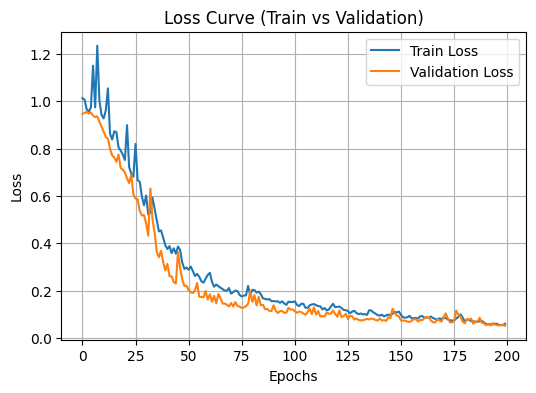

In [78]:
# =============================================
# ====== 10. Final Training with Loss Curve ======
# =============================================
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=seed)
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
val_losses   = []

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(final_loader))

    # Validation loss
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = final_model(xb)
            val_loss += criterion(preds, yb).item()
    val_losses.append(val_loss / len(val_loader))

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve (Train vs Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [79]:
# =============================================
# ====== 11. Final Evaluation (Train/Val/Test) ======
# =============================================
def evaluate(model, loader, scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = scaler.inverse_transform(preds)
            yb_orig = scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred


train_true, train_pred = evaluate(final_model, final_loader, y_scaler)
val_true, val_pred     = evaluate(final_model, val_loader, y_scaler)
test_true, test_pred   = evaluate(final_model, test_loader, y_scaler)

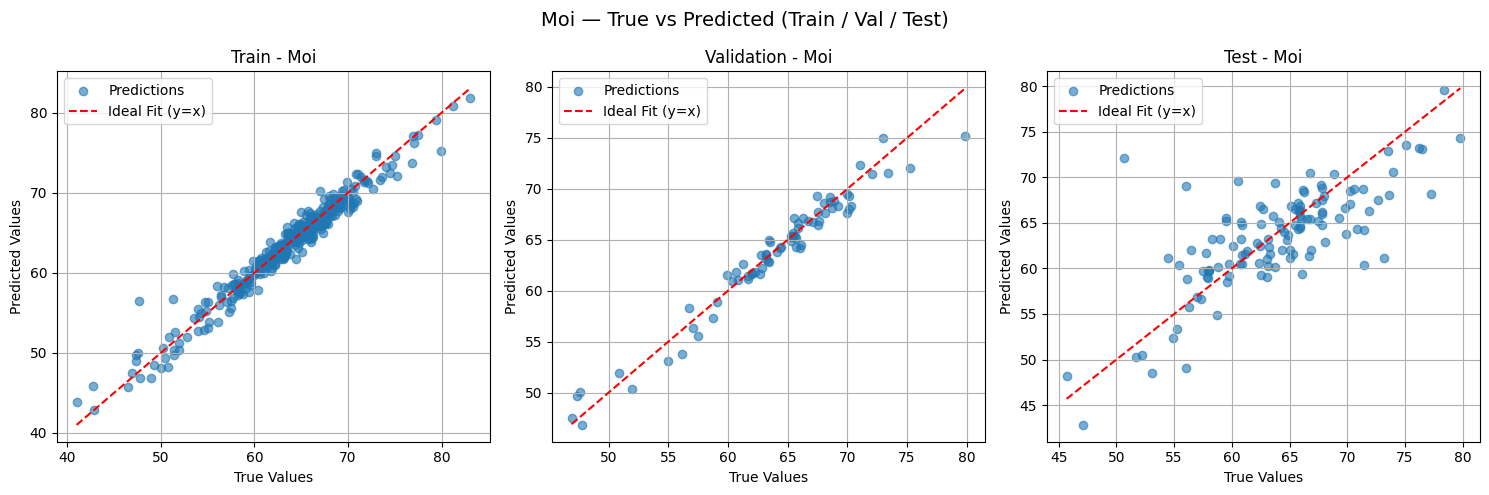

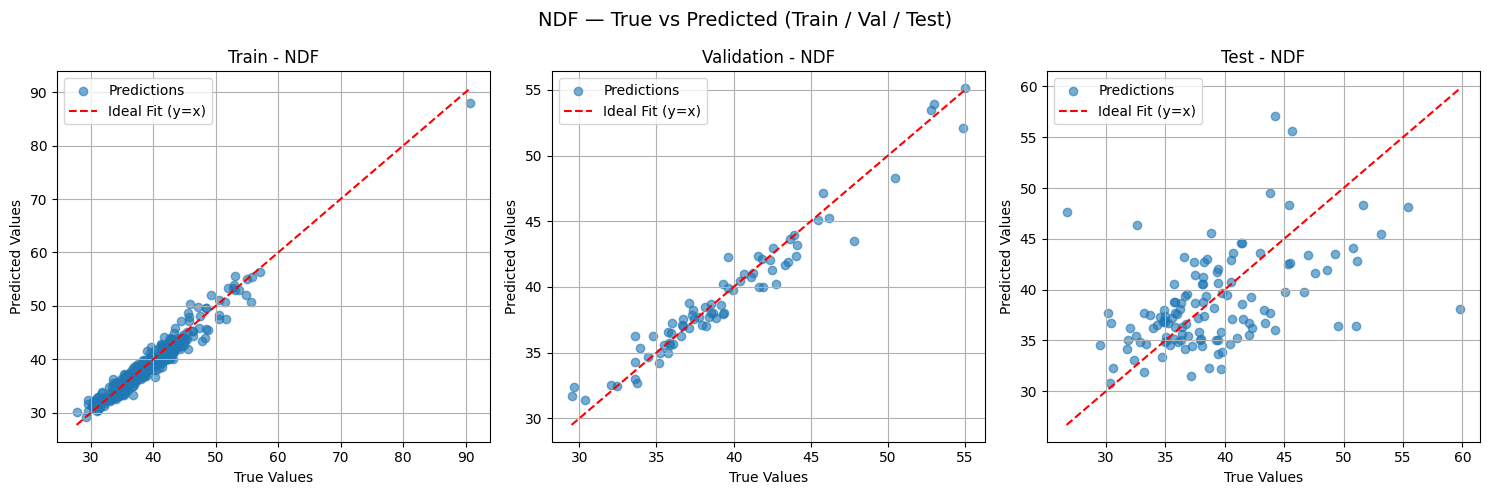

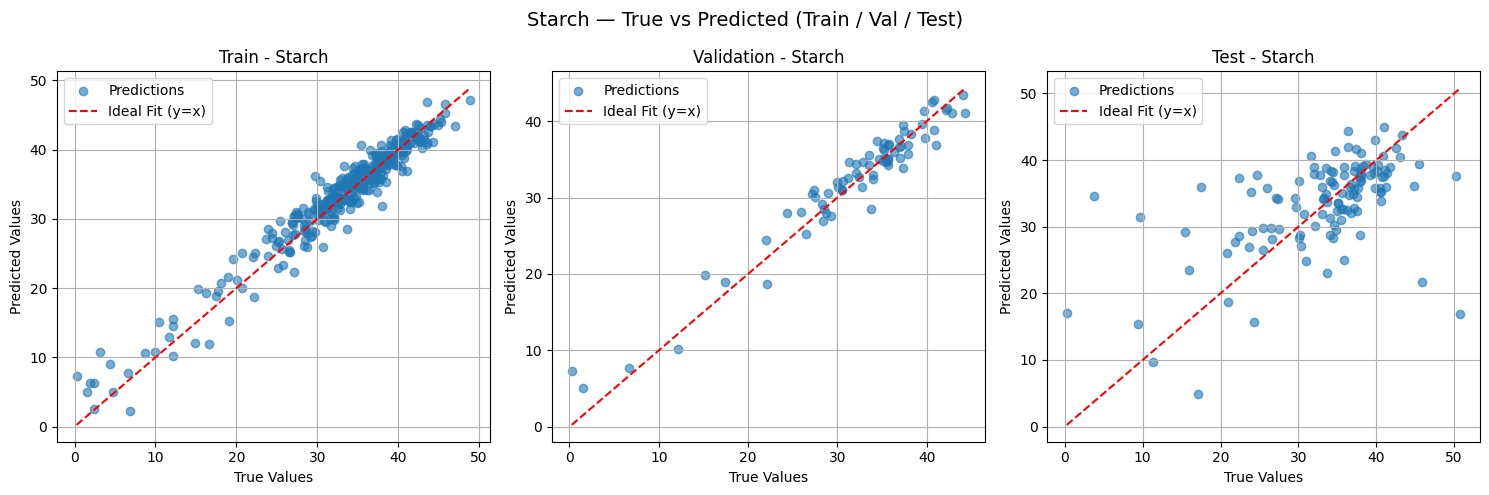

In [80]:
# =============================================
# ====== 12. Plot All Targets (Train/Val/Test) ======
# =============================================
for i, t in enumerate(TARGETS):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    datasets = [("Train", train_true, train_pred),
                ("Validation", val_true, val_pred),
                ("Test", test_true, test_pred)]

    for ax, (name, y_true, y_pred) in zip(axes, datasets):
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.set_title(f"{name} - {t}")
        ax.legend()
        ax.grid(True)

    plt.suptitle(f"{t} — True vs Predicted (Train / Val / Test)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [81]:
# =============================================
# ====== 13. Compute and Print Metrics ======
# =============================================
def print_metrics(name, y_true, y_pred):
    metrics = compute_metrics_orig(y_true, y_pred)
    print(f"\n📊 {name} Results:")
    for i, t in enumerate(TARGETS):
        rmse = metrics[i]['RMSE']
        r2   = metrics[i]['R2']
        bias = metrics[i]['Bias']
        print(f"🎯 {t}:    R²: {r2:.3f}    RMSE: {rmse:.3f}    Bias: {bias:.3f}")

print_metrics("Train", train_true, train_pred)
print_metrics("Validation", val_true, val_pred)
print_metrics("Test", test_true, test_pred)



📊 Train Results:
🎯 Moi:    R²: 0.959    RMSE: 1.243    Bias: -0.128
🎯 NDF:    R²: 0.947    RMSE: 1.345    Bias: -0.202
🎯 Starch:    R²: 0.942    RMSE: 2.004    Bias: 0.400

📊 Validation Results:
🎯 Moi:    R²: 0.958    RMSE: 1.294    Bias: -0.228
🎯 NDF:    R²: 0.947    RMSE: 1.230    Bias: -0.114
🎯 Starch:    R²: 0.939    RMSE: 2.145    Bias: 0.376

📊 Test Results:
🎯 Moi:    R²: 0.541    RMSE: 4.241    Bias: -0.414
🎯 NDF:    R²: 0.083    RMSE: 5.379    Bias: -0.369
🎯 Starch:    R²: 0.238    RMSE: 7.533    Bias: 0.382


In [ ]:
# =============================================
# ====== 14. Save Final Model ======
# =============================================
file_path = f"/content/CR_16_norm.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")

In [ ]:
# =============================================
# ====== 15. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
